### Load 3D data, preprocess and save as numpy array

In [9]:
import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import h5py
import helpers as H
from tqdm import tqdm

#Root directory of the project
ROOT_DIR = os.path.abspath(".")
TRAIN_DATASET_PATH = os.path.join(ROOT_DIR, "dataset")
train_data_paths = os.listdir(os.path.join(TRAIN_DATASET_PATH, "img_datas_1"))
print(len(train_data_paths))

218


In [10]:
def dir_test(path):
    return len(os.listdir(path))

w, h = 128, 128
def rs_img(img):
    '''W and H is 128 now
    '''
    #H.normalize
    flatten = [cv2.resize(img[:,:,i], (w, h), interpolation=cv2.INTER_CUBIC) for i in range(img.shape[-1])]
    img = np.array(np.dstack(flatten)) 
    return img

def change_depth(img):
    '''Depth is 32 now
    '''
    #img_start = img[:,:,:8]
    
    mid = int(img.shape[-1]/2)
    img_middle = img[:,:,mid-16:mid+16]
    
    #img_end = img[:,:,-8:]
    #img = np.concatenate((img_start, img_middle, img_end), axis=2)
    img = img_middle
    
    return img

def get_number(filename):
    return int(filename[:filename.find('.')])

def sort_paths(paths):
    paths.sort(key = get_number)
    return paths

def load_numpy(path):
    val = np.load(path)
    print(val.shape)
    return val

def expand_dims(val):
    val_exp = np.expand_dims(val, axis=4)
    return val_exp

def plot_slice(img, sl_num):
    plt.imshow(img[:,:,sl_num])


def to_3D(arr, resize_dim=None):
    '''Stack 2D slice to add dummy 3-channel dimension'''
    img = np.asarray(np.dstack((arr, arr, arr)), dtype=np.float64)
    if resize_dim is not None:
        img=cv2.resize(img,(resize_dim, resize_dim),interpolation=cv2.INTER_AREA)    
    else:
        pass
    return img

In [11]:
train_data_paths[:4]

['1.npy', '10.npy', '100.npy', '101.npy']

In [12]:
sort_paths(train_data_paths)[:5]

['1.npy', '2.npy', '3.npy', '4.npy', '5.npy']

In [13]:
norm_path = os.path.join(TRAIN_DATASET_PATH, "3D_images_normalized")
norm_path

'E:\\ECIR_2020\\ecir2020\\3D\\dataset\\3D_images_normalized'

In [14]:
H.create_directory(os.path.join(norm_path))

In [17]:
c = 0
for path in train_data_paths[:]:
    
    # Load data
    img = np.load(TRAIN_DATASET_PATH + "{}/{}".format("/img_datas_1/", path))
    
    # Segment lung and normalize
    img_rs = np.transpose(img, (2, 0, 1)) # CHW
    
    # Lung segmentation, padding if needed, threshold -1100 to 700, divide all vals with 1100 to bring to -1 to 1
    img_rs = H.seperate_lungs_and_pad(img_rs)
    img_rs = H.threshold_and_normalize_scan(img_rs)
    
    img_rs = np.transpose(img_rs, (1, 2, 0)) # HWC

    # Resize w, h 
    img_rs = rs_img(img_rs)
    
    # Resize depth
    img_rs = change_depth(img_rs)
    
    
    c+=1
    print(c, "--", path, "-----", img.shape, "-------", img_rs.shape)
    # Save
    np.save(norm_path + "/{}.npy".format(c), img_rs)
    img = None
    
print("Done")

1 -- 1.npy ----- (512, 512, 128) ------- (128, 128, 32)
2 -- 2.npy ----- (512, 512, 122) ------- (128, 128, 32)
3 -- 3.npy ----- (512, 512, 113) ------- (128, 128, 32)
4 -- 4.npy ----- (512, 512, 120) ------- (128, 128, 32)
5 -- 5.npy ----- (512, 512, 116) ------- (128, 128, 32)
6 -- 6.npy ----- (512, 512, 131) ------- (128, 128, 32)
7 -- 7.npy ----- (512, 512, 123) ------- (128, 128, 32)
8 -- 8.npy ----- (512, 512, 132) ------- (128, 128, 32)
9 -- 9.npy ----- (512, 512, 144) ------- (128, 128, 32)
10 -- 10.npy ----- (512, 512, 131) ------- (128, 128, 32)
11 -- 11.npy ----- (512, 512, 133) ------- (128, 128, 32)
12 -- 12.npy ----- (512, 512, 132) ------- (128, 128, 32)
13 -- 13.npy ----- (512, 512, 129) ------- (128, 128, 32)
14 -- 14.npy ----- (512, 512, 116) ------- (128, 128, 32)
15 -- 15.npy ----- (512, 512, 130) ------- (128, 128, 32)
16 -- 16.npy ----- (512, 512, 125) ------- (128, 128, 32)
17 -- 17.npy ----- (512, 512, 104) ------- (128, 128, 32)
18 -- 18.npy ----- (512, 512, 11

In [19]:
len(os.listdir(norm_path))

218

### Check saved image distribution

In [20]:
img = np.load(norm_path + "/1.npy")
img.shape

(128, 128, 32)

-1.1153808 0.82402873


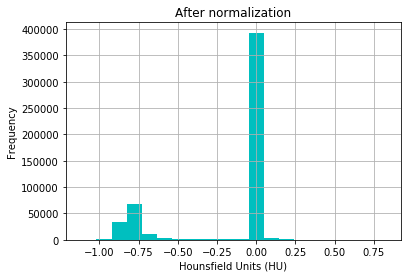

In [21]:
img_flat = img.flatten()
print(min(img_flat), max(img_flat))
plt.hist(img_flat, bins=20, color='c')
plt.title("After normalization")
plt.xlabel("Hounsfield Units (HU)")
plt.grid(True)
plt.ylabel("Frequency")
plt.show()

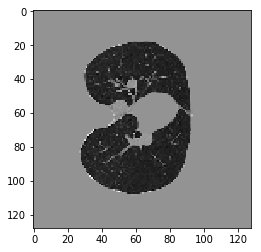

In [28]:
plt.imshow(img[:,:,22], cmap='gray')

In [23]:
norm_path

'E:\\ECIR_2020\\ecir2020\\3D\\dataset\\3D_images_normalized'

In [24]:
sort_paths(os.listdir(norm_path))[:4]

['1.npy', '2.npy', '3.npy', '4.npy']

In [15]:
x_train = []
c = 0
for path in sort_paths(os.listdir(norm_path))[:]:
    img = None
    img = np.load(norm_path+ "/{}".format(path))
    
    # slice and dice
    x_train.append(img)
    c+=1
    print(c, "----", norm_path + "/" + path, img.shape)

x_train = np.array(x_train)
x_train.shape

1 ---- E:\ECIR_2020\ecir2020\3D\dataset\3D_images_normalized/1.npy (128, 128, 32)
2 ---- E:\ECIR_2020\ecir2020\3D\dataset\3D_images_normalized/2.npy (128, 128, 32)
3 ---- E:\ECIR_2020\ecir2020\3D\dataset\3D_images_normalized/3.npy (128, 128, 32)
4 ---- E:\ECIR_2020\ecir2020\3D\dataset\3D_images_normalized/4.npy (128, 128, 32)
5 ---- E:\ECIR_2020\ecir2020\3D\dataset\3D_images_normalized/5.npy (128, 128, 32)
6 ---- E:\ECIR_2020\ecir2020\3D\dataset\3D_images_normalized/6.npy (128, 128, 32)
7 ---- E:\ECIR_2020\ecir2020\3D\dataset\3D_images_normalized/7.npy (128, 128, 32)
8 ---- E:\ECIR_2020\ecir2020\3D\dataset\3D_images_normalized/8.npy (128, 128, 32)
9 ---- E:\ECIR_2020\ecir2020\3D\dataset\3D_images_normalized/9.npy (128, 128, 32)
10 ---- E:\ECIR_2020\ecir2020\3D\dataset\3D_images_normalized/10.npy (128, 128, 32)
11 ---- E:\ECIR_2020\ecir2020\3D\dataset\3D_images_normalized/11.npy (128, 128, 32)
12 ---- E:\ECIR_2020\ecir2020\3D\dataset\3D_images_normalized/12.npy (128, 128, 32)
13 ---- E:

(218, 128, 128, 32)

In [16]:
x_train = expand_dims(x_train)
x_train.shape

(218, 128, 128, 32, 1)

In [18]:
np.save("x_train_3D.npy", x_train)

In [19]:
print("Done!")

Done!
